# **Feature Engineering Notebook**


## Objectives

Engineer useful features for regression modeling by:
- Applying categorical encodings
- Transforming skewed numerical variables
- Handling outliers and rare values
- Saving final feature matrices for model input

### Inputs
- `outputs/datasets/cleaned/TrainSetCleaned.csv`
- `outputs/datasets/cleaned/TestSetCleaned.csv`

### Outputs
- `outputs/datasets/preprocessed/X_train.csv`
- `outputs/datasets/preprocessed/X_test.csv`


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-house-price-predictor/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-house-price-predictor'

In [4]:
import os
print("Top-level folders:")
print(os.listdir("/workspaces"))

Top-level folders:
['heritage-house-price-predictor', '.codespaces']


In [5]:
os.chdir("/workspaces/heritage-house-price-predictor")
print(" Now in:", os.getcwd())

 Now in: /workspaces/heritage-house-price-predictor


## Setup and Load Data

We now load the cleaned Train and Test datasets created during the Data Cleaning stage.  
These datasets are ready for feature engineering.

In [6]:
import pandas as pd

train_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
test_path = "outputs/datasets/cleaned/TestSetCleaned.csv"

TrainSet = pd.read_csv(train_path)
TestSet = pd.read_csv(test_path)

TrainSet.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1232,0.0,2.0,Av,724,GLQ,508,632,NaN,2007.0,...,7314,64.0,82.0,0,5,7,1232,2007,2007,194500
1,1445,689.0,5.0,No,0,Unf,844,441,Unf,1930.0,...,11888,69.0,0.0,60,6,6,844,1916,1994,214500
2,1337,0.0,3.0,Mn,699,GLQ,638,531,RFn,2003.0,...,8450,65.0,0.0,39,5,7,1337,2003,2003,185000
3,958,0.0,2.0,No,120,ALQ,958,440,RFn,1977.0,...,4928,69.0,0.0,205,5,6,1078,1976,1976,128000
4,1134,0.0,2.0,No,588,NaN,422,254,NaN,1960.0,...,7000,70.0,45.0,16,7,5,1010,1960,2002,135000


---

## Feature Engineering Utility Function

We define a custom function called `FeatureEngineeringAnalysis()` to evaluate how different feature transformations affect our variables.

This function helps us decide which transformations are most appropriate by:

- Visualizing the **distribution** (via histogram)
- Checking **normality** (via QQ plot)
- Identifying **outliers** (via boxplot)

We can use it to evaluate:
- **Ordinal Encoding** (for categorical features)
- **Numerical Transformation** (log, power, etc.)
- **Outlier Winsorization**

In [7]:

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

def FeatureEngineeringAnalysis(df, analysis_type=None):
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]
        df_feat_eng, list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)
        transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)
    return df_feat_eng

def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    if analysis_type is None:
        raise SystemExit(f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(f"analysis_type argument should be one of these options: {allowed_types}")

def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit("There is a missing value in your dataset. Please handle that before getting into feature engineering.")

def define_list_column_transformers(analysis_type):
    if analysis_type == 'numerical':
        return ["log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]
    elif analysis_type == 'ordinal_encoder':
        return ["ordinal_encoder"]
    elif analysis_type == 'outlier_winsorizer':
        return ['iqr']

def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')
    if analysis_type == 'numerical':
        return FeatEngineering_Numerical(df_feat_eng, column)
    elif analysis_type == 'outlier_winsorizer':
        return FeatEngineering_OutlierWinsorizer(df_feat_eng, column)
    elif analysis_type == 'ordinal_encoder':
        return FeatEngineering_CategoricalEncoder(df_feat_eng, column)

def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:
        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)
        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)
        print("\n")

def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=['#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")

def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])
    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()

def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")
    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)
    return df_feat_eng, list_methods_worked

def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []
    try:
        disc = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)
    return df_feat_eng, list_methods_worked

def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []
    for method, transformer in [
        ("log_e", vt.LogTransformer(variables=[f"{column}_log_e"])),
        ("log_10", vt.LogTransformer(variables=[f"{column}_log_10"], base='10')),
        ("reciprocal", vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])),
        ("power", vt.PowerTransformer(variables=[f"{column}_power"])),
        ("box_cox", vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])),
        ("yeo_johnson", vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])),
    ]:
        try:
            df_feat_eng = transformer.fit_transform(df_feat_eng)
            list_methods_worked.append(f"{column}_{method}")
        except Exception:
            df_feat_eng.drop([f"{column}_{method}"], axis=1, inplace=True)
    return df_feat_eng, list_methods_worked


---

## Ordinal Encoding

We will apply ordinal encoding to selected categorical variables where the categories have an inherent order or consistent representation.

**Variables selected**:
- BsmtExposure
- BsmtFinType1
- GarageFinish
- KitchenQual

These features are common in housing data and describe quality or exposure levels which can be sensibly mapped to numeric scales.

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



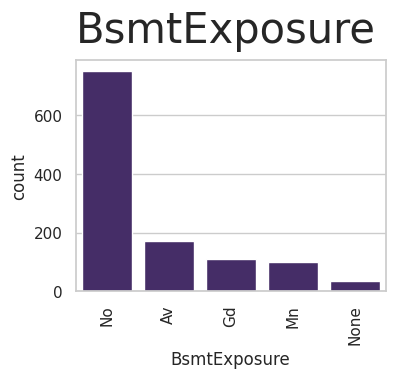

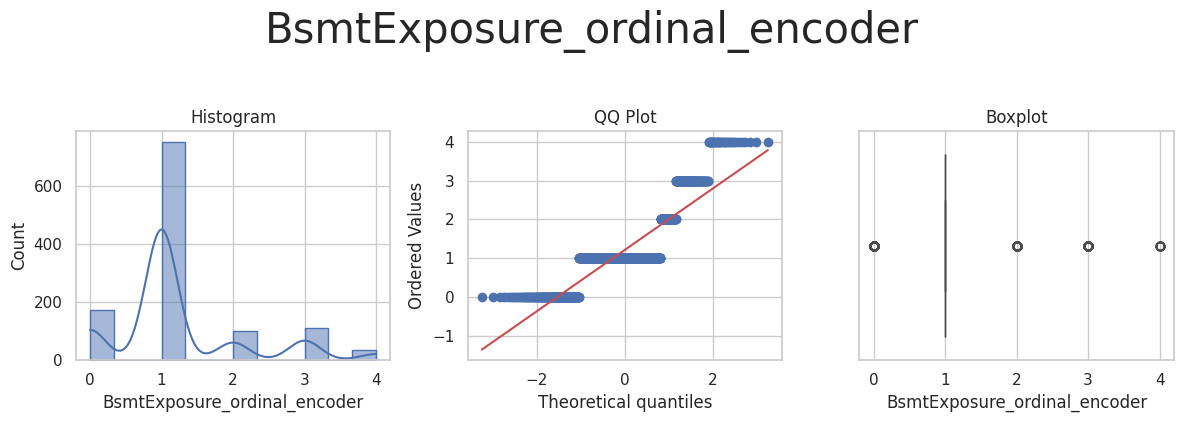



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



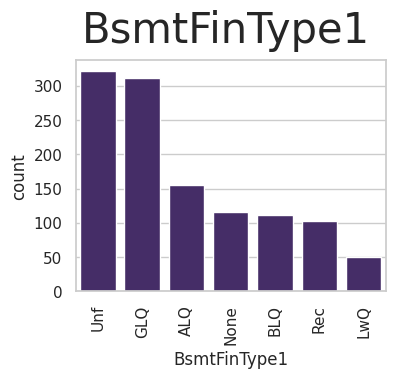

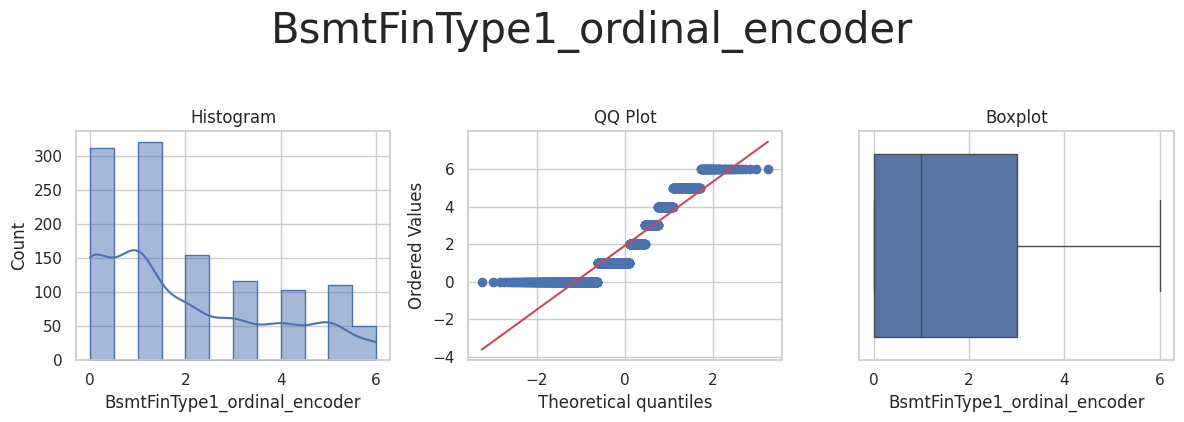



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



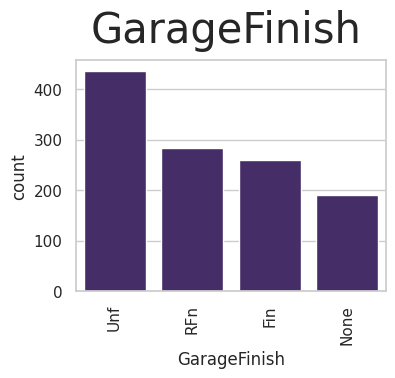

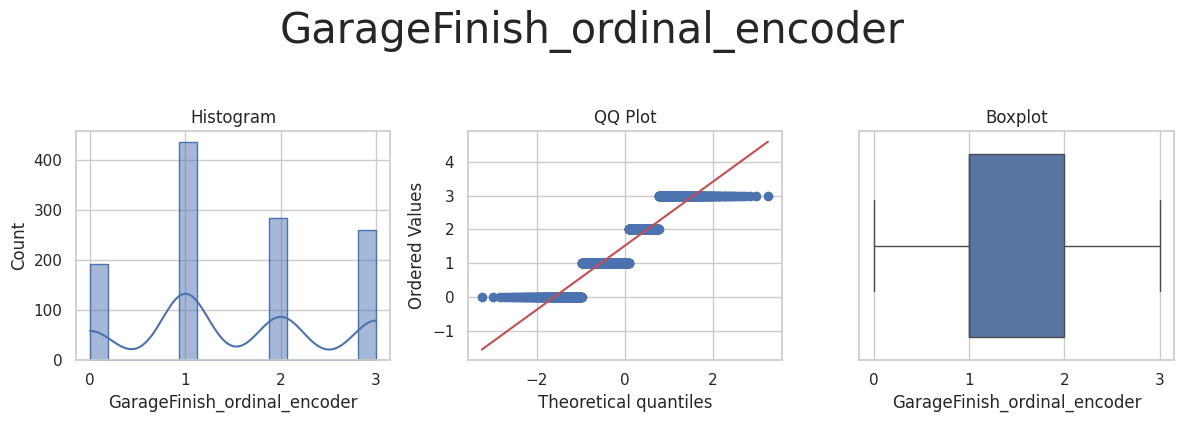



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



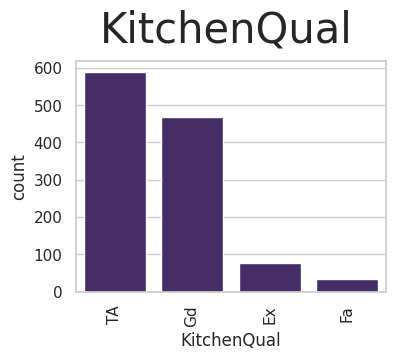

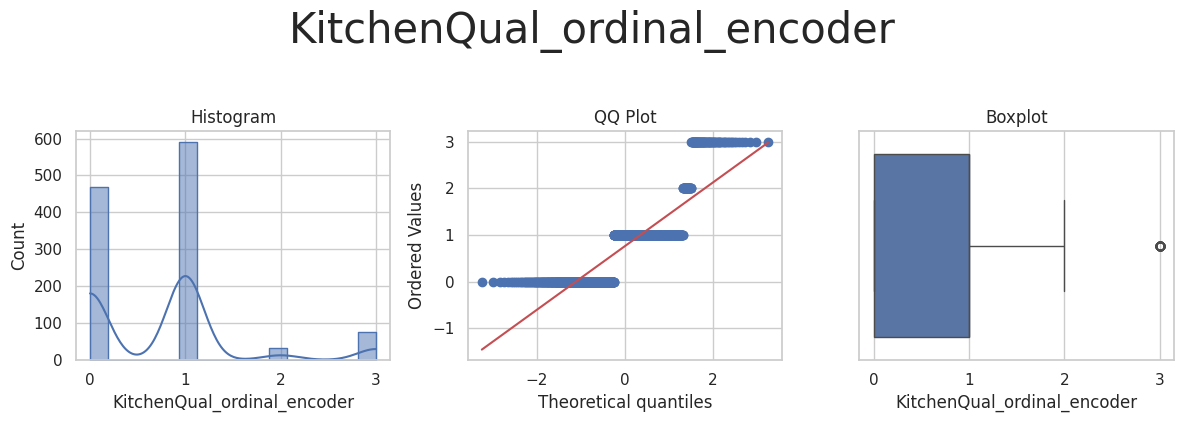

In [8]:
# Step 1: Load dataset if not already loaded
import pandas as pd

df_train = pd.read_csv("outputs/datasets/cleaned/TrainSetCleaned.csv")

# Step 2: Select variables for ordinal encoding
variables_engineering = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

# Step 3: Create a working copy and handle missing values with 'None'
df_engineering = df_train[variables_engineering].copy()
df_engineering = df_engineering.fillna('None')  # OrdinalEncoder in FeatureEngineeringAnalysis expects no missing values

# Step 4: Apply custom FeatureEngineeringAnalysis
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

### Result Evaluation

The diagnostic plots above show the distributions of each feature before and after ordinal encoding.

**Next Steps**:
- Select the newly created columns ending in `_ordinal_encoder`.
- Drop original columns and merge the engineered ones into your full feature set.

In [9]:
# Step 5: Extract encoded columns and update main feature set
engineered_columns = [f"{col}_ordinal_encoder" for col in variables_engineering]

# Keep only the new engineered features
X_encoded = df_engineering[engineered_columns]

# Optional: Merge into original training set
X_train_updated = pd.concat([df_train.drop(columns=variables_engineering), X_encoded], axis=1)

# Preview updated dataset
X_train_updated.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,GarageArea,GarageYrBlt,GrLivArea,LotArea,LotFrontage,...,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice,BsmtExposure_ordinal_encoder,BsmtFinType1_ordinal_encoder,GarageFinish_ordinal_encoder,KitchenQual_ordinal_encoder
0,1232,0.0,2.0,724,508,632,2007.0,1232,7314,64.0,...,5,7,1232,2007,2007,194500,0,0,0,0
1,1445,689.0,5.0,0,844,441,1930.0,2134,11888,69.0,...,6,6,844,1916,1994,214500,1,1,1,0
2,1337,0.0,3.0,699,638,531,2003.0,1337,8450,65.0,...,5,7,1337,2003,2003,185000,2,0,2,0
3,958,0.0,2.0,120,958,440,1977.0,958,4928,69.0,...,5,6,1078,1976,1976,128000,1,2,2,1
4,1134,0.0,2.0,588,422,254,1960.0,1134,7000,70.0,...,7,5,1010,1960,2002,135000,1,3,0,1


---

## Transforming Skewed Numerical Features

Some numerical features in the Heritage Housing dataset are highly skewed (e.g., `LotArea`, `GrLivArea`, `MasVnrArea`), which can affect the performance of regression models.

To address this, we will:
- Select skewed numerical variables
- Apply various transformations using `FeatureEngineeringAnalysis`
- Visualize the effect of each transformation
- Select the best versions to include in our final dataset

* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



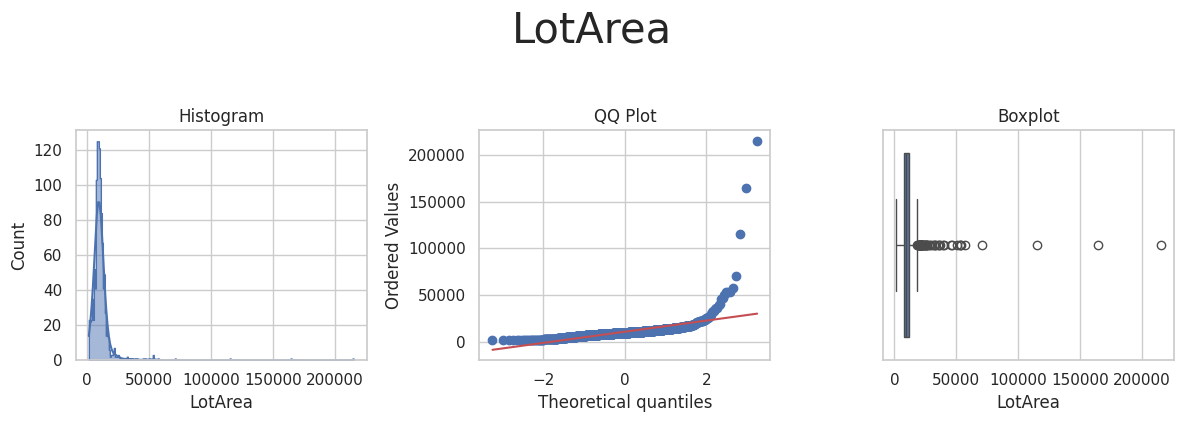

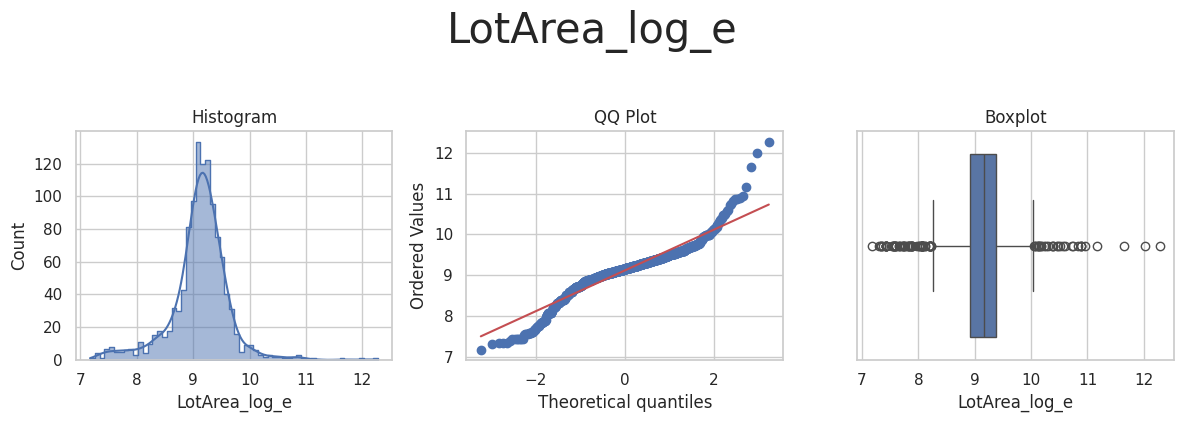

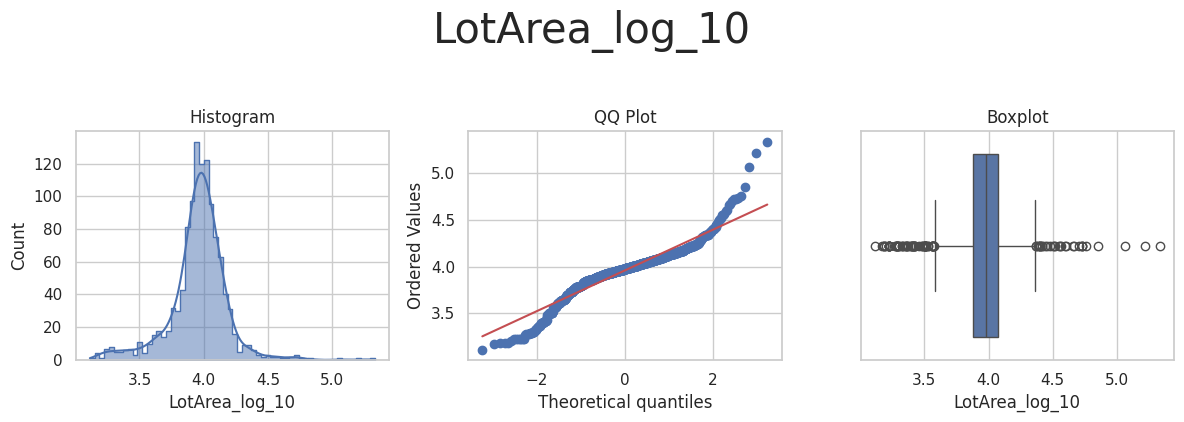

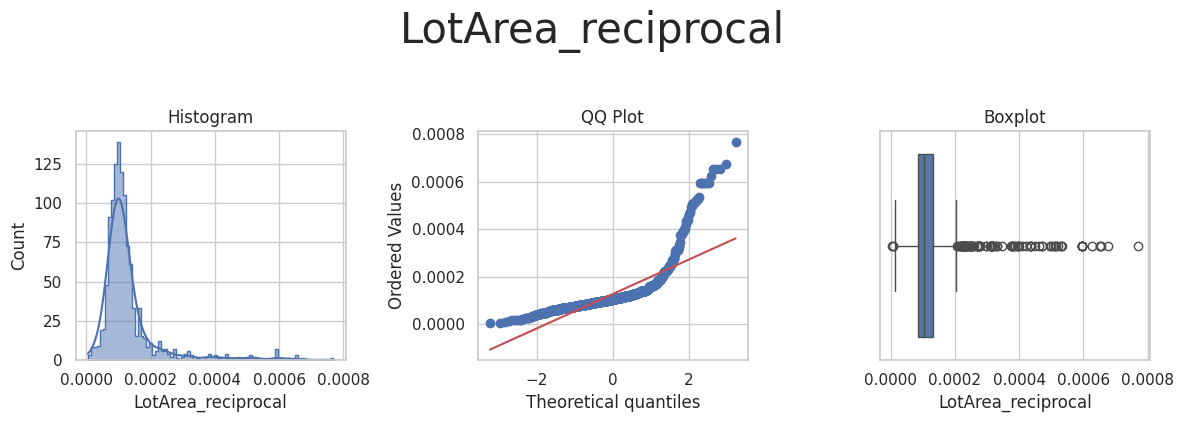

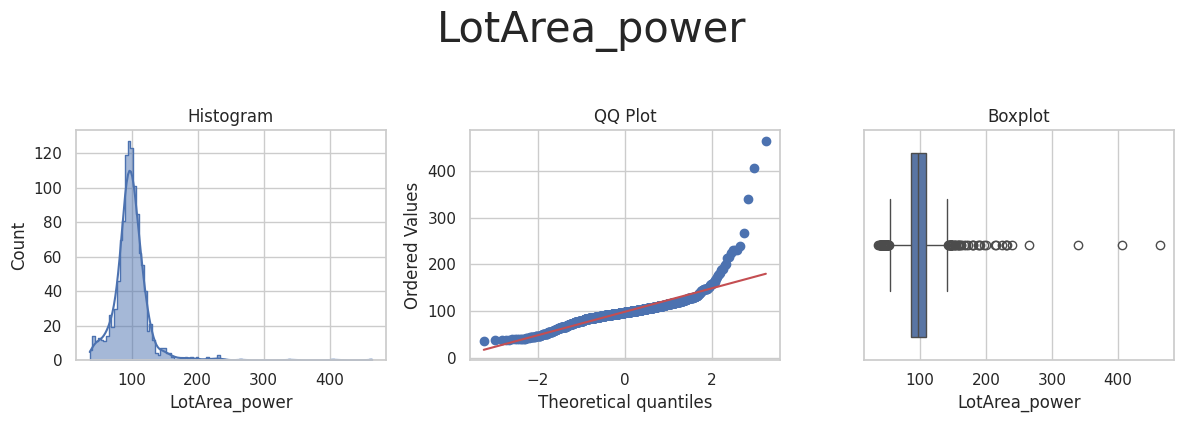

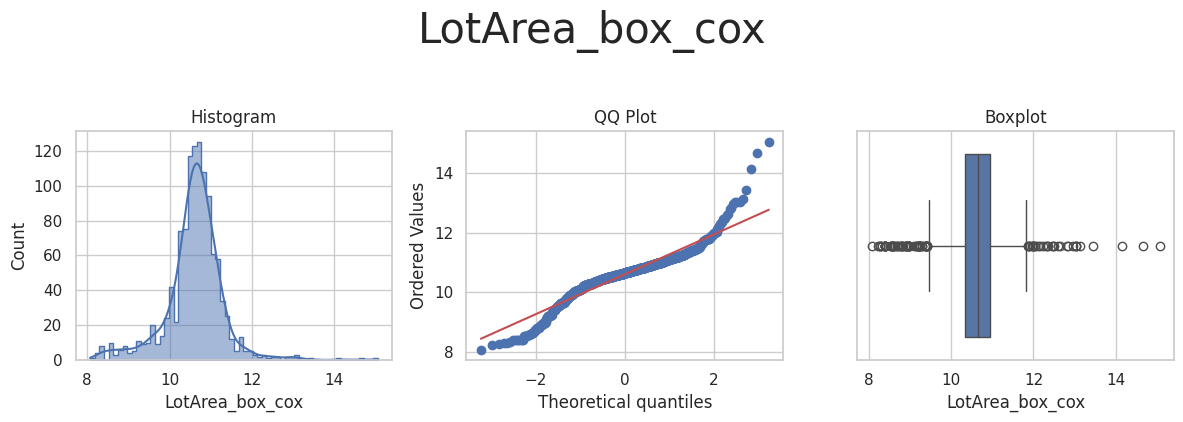

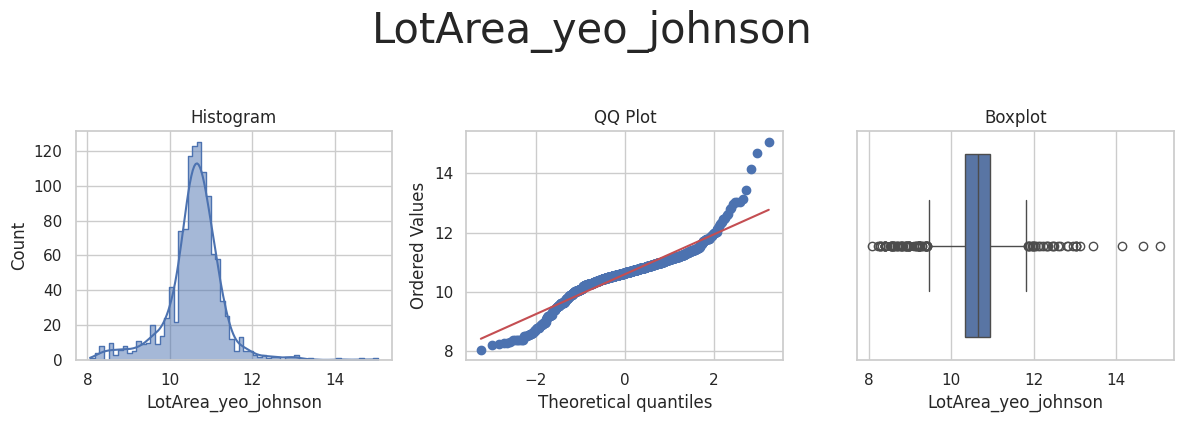



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



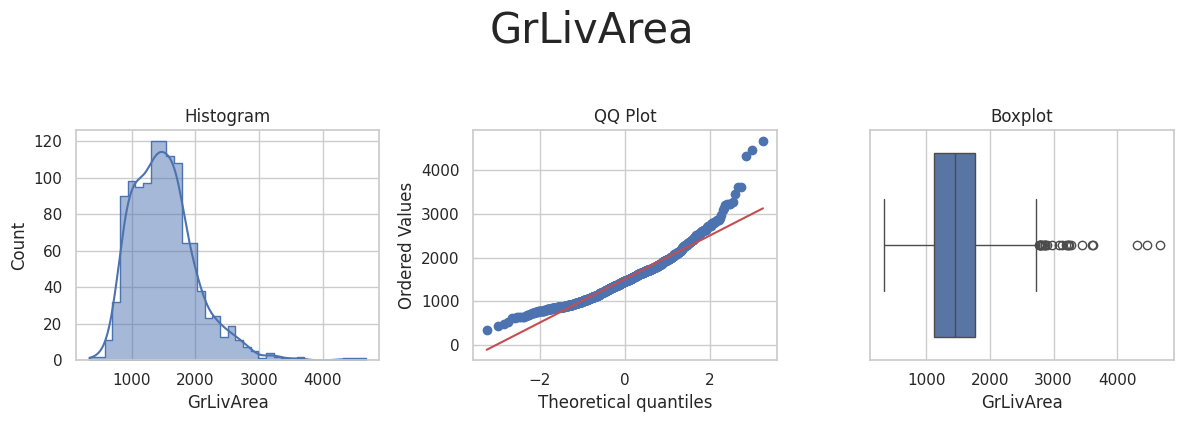

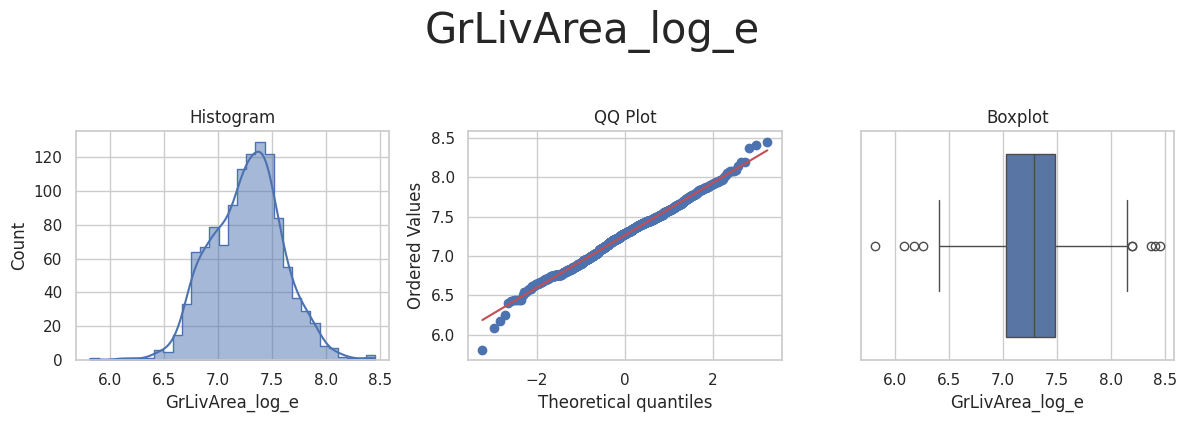

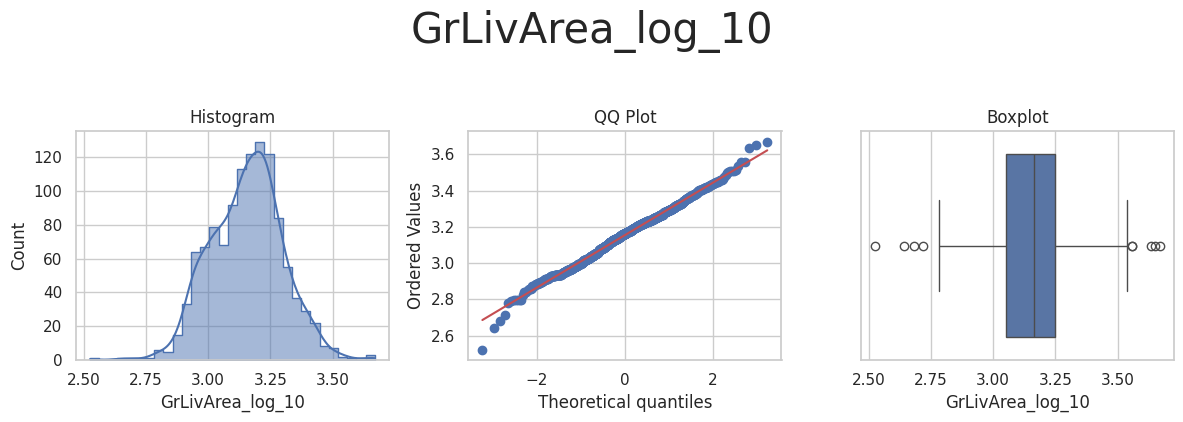

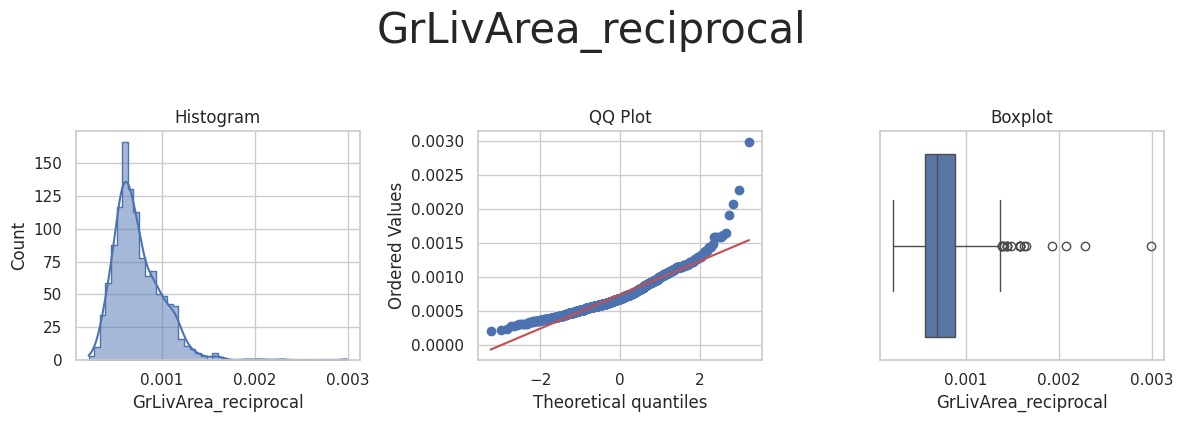

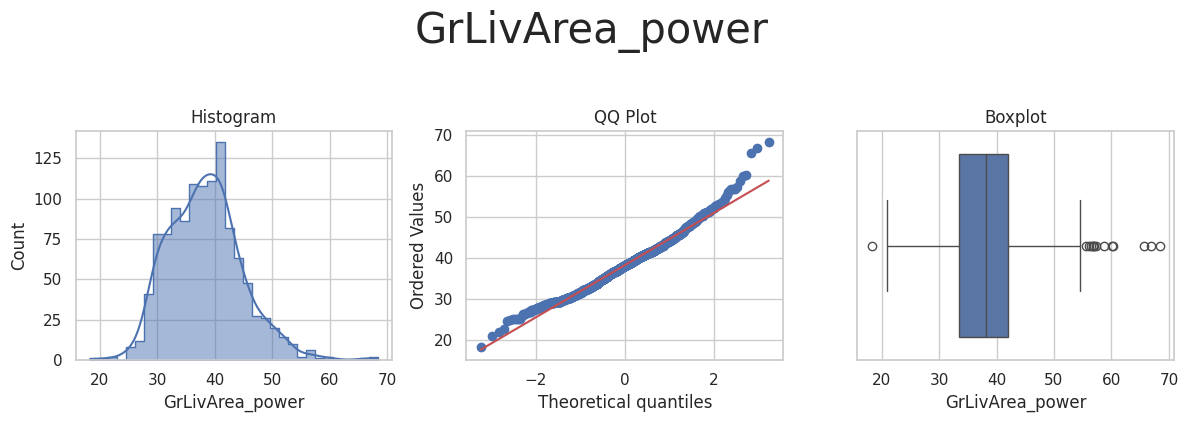

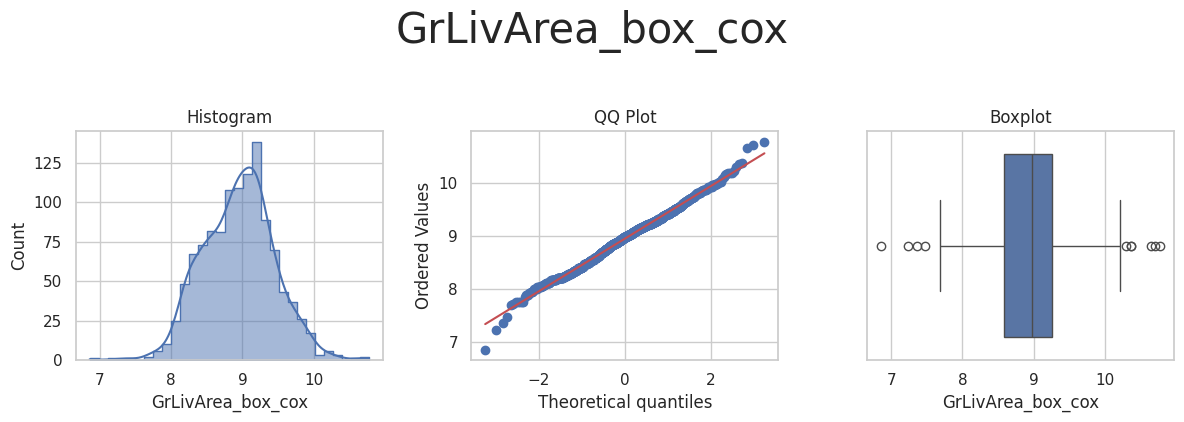

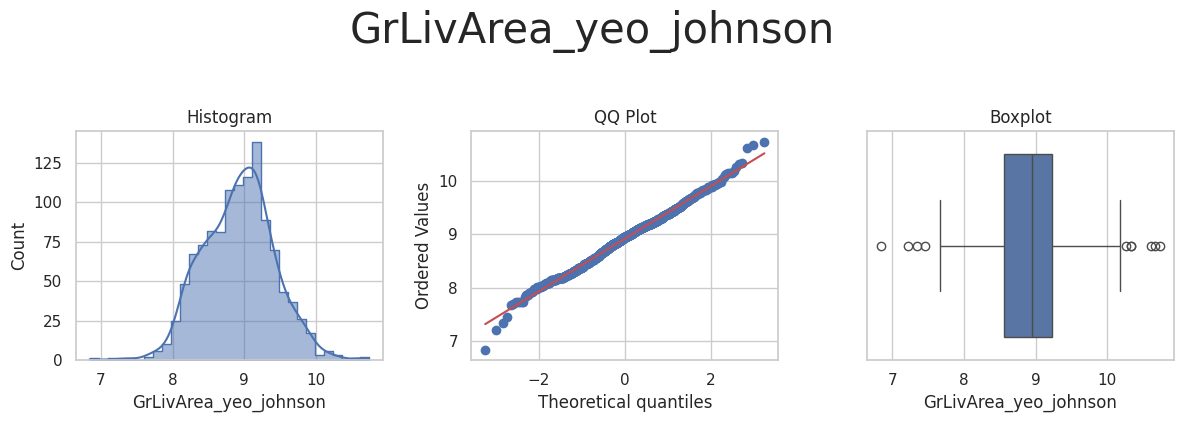



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



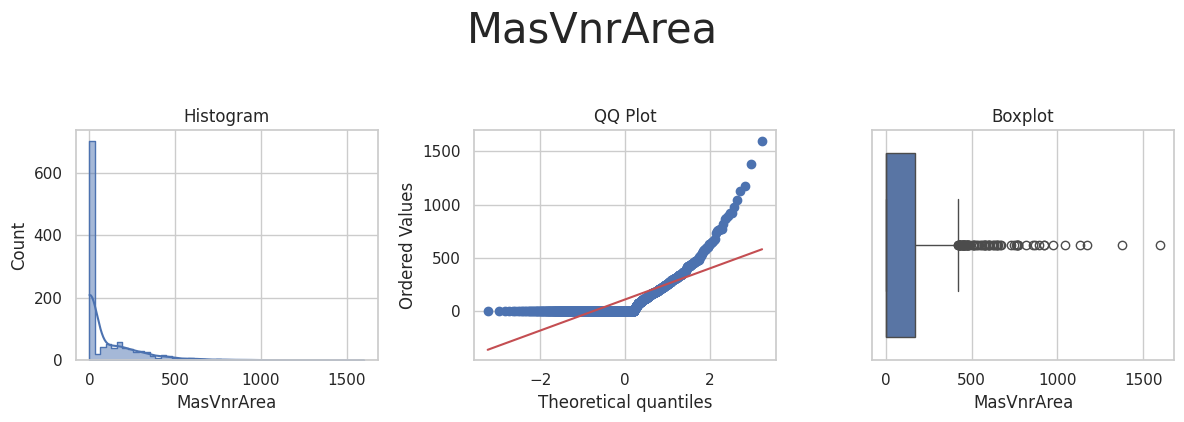

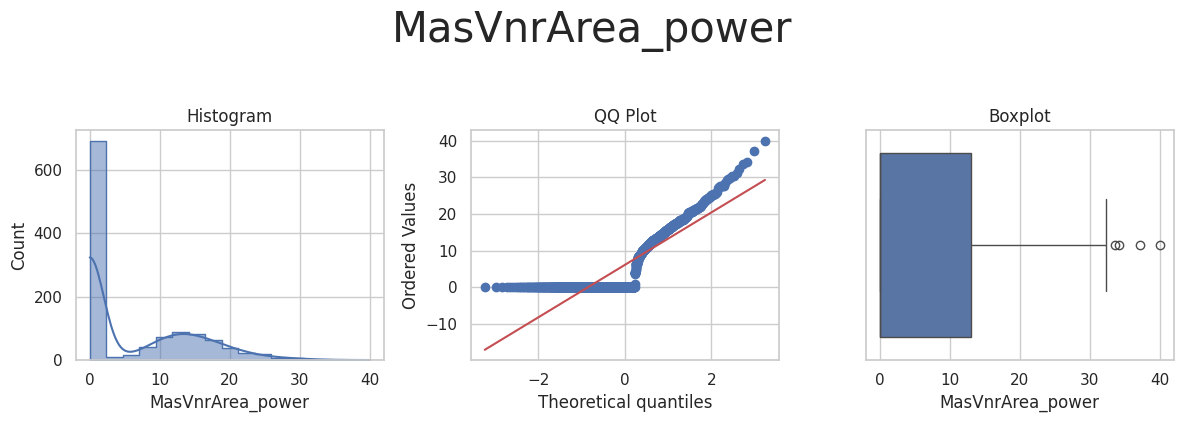

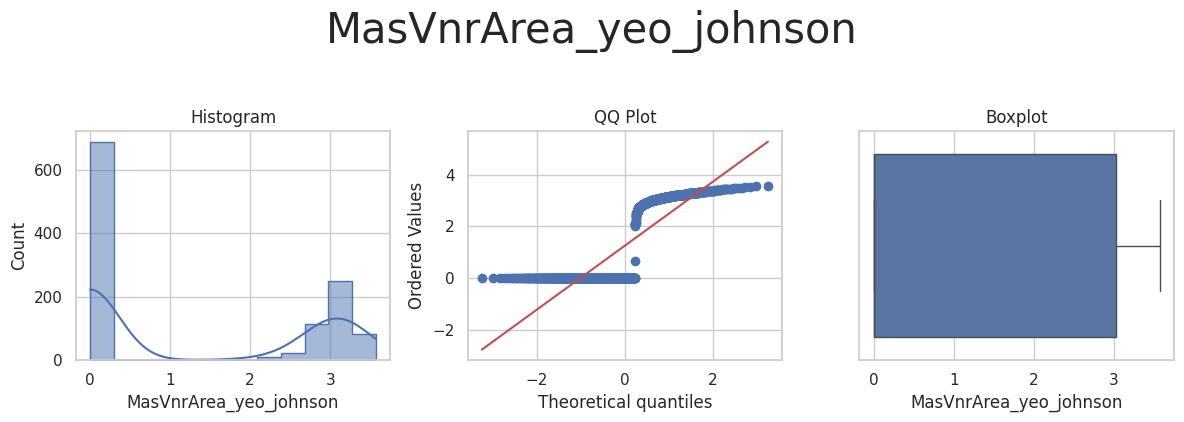



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



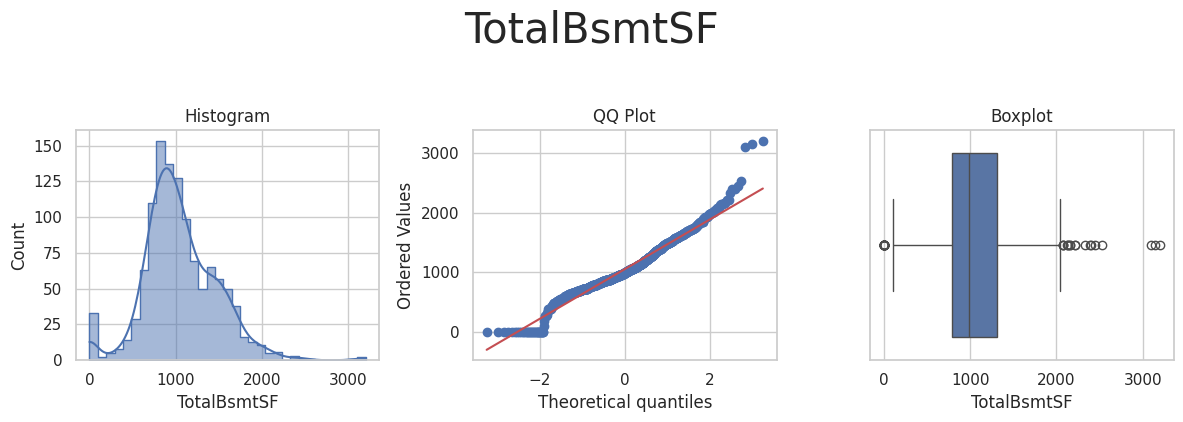

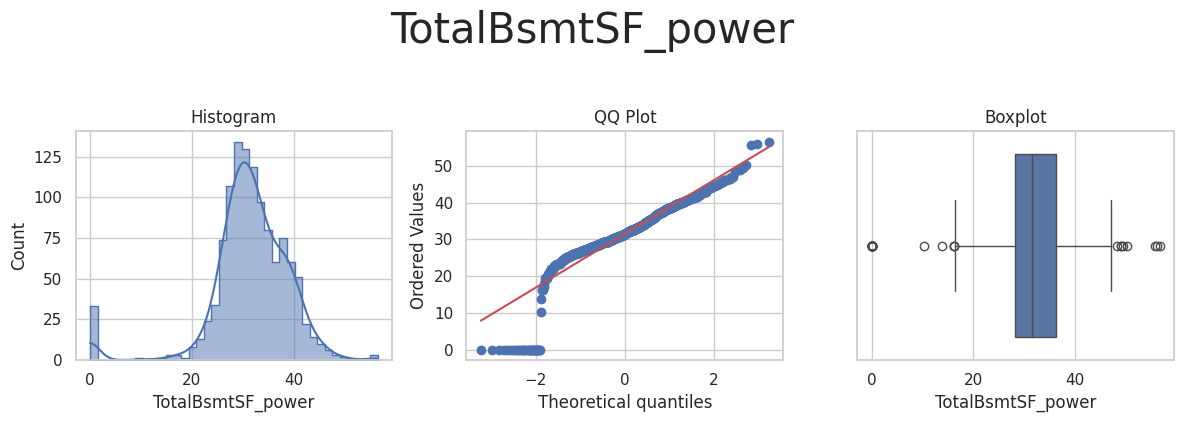

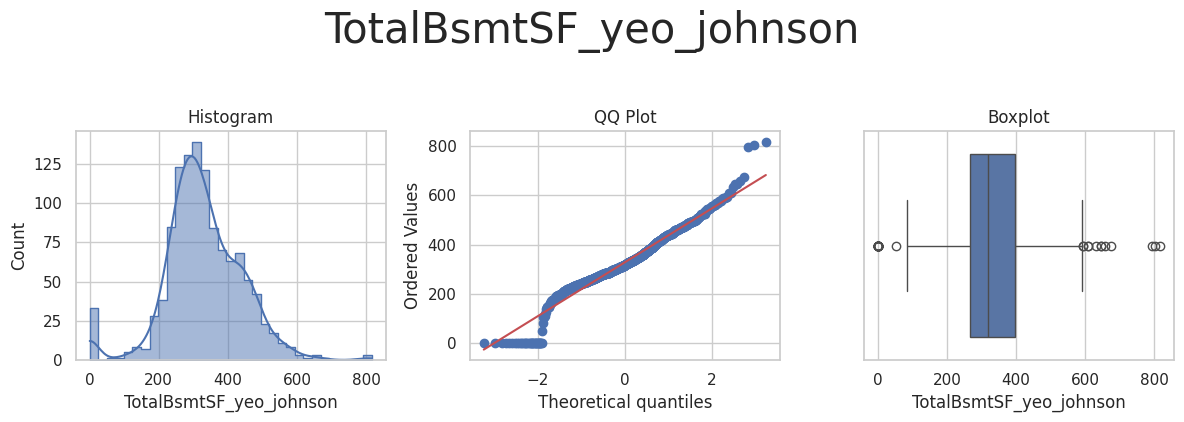



* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



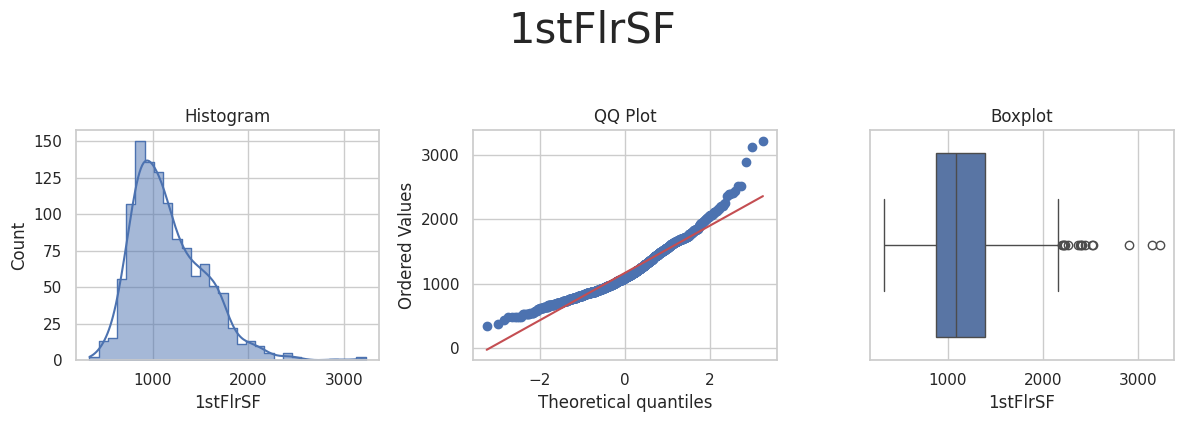

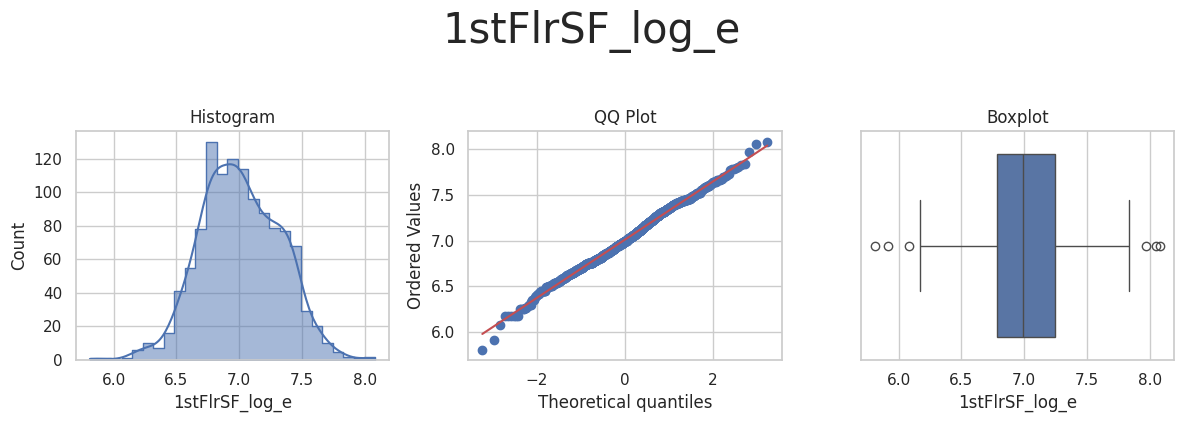

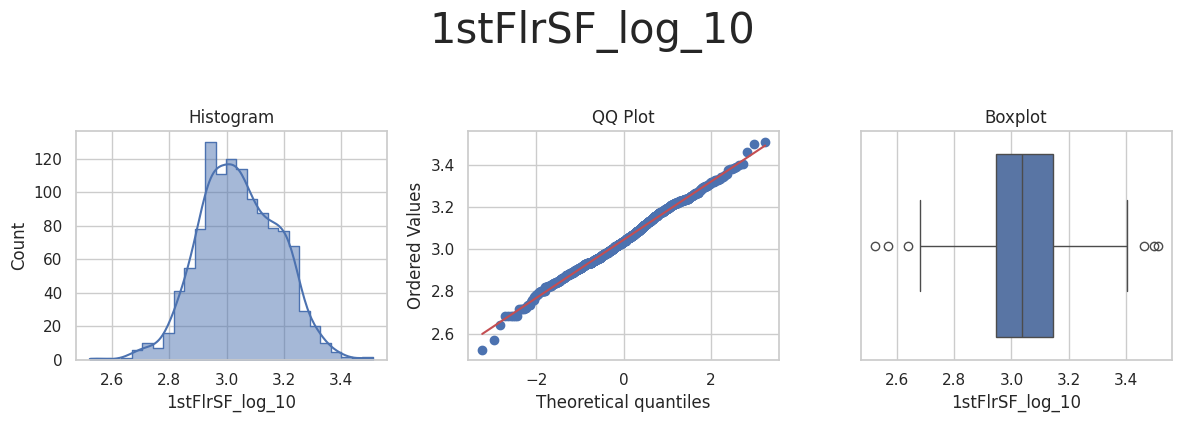

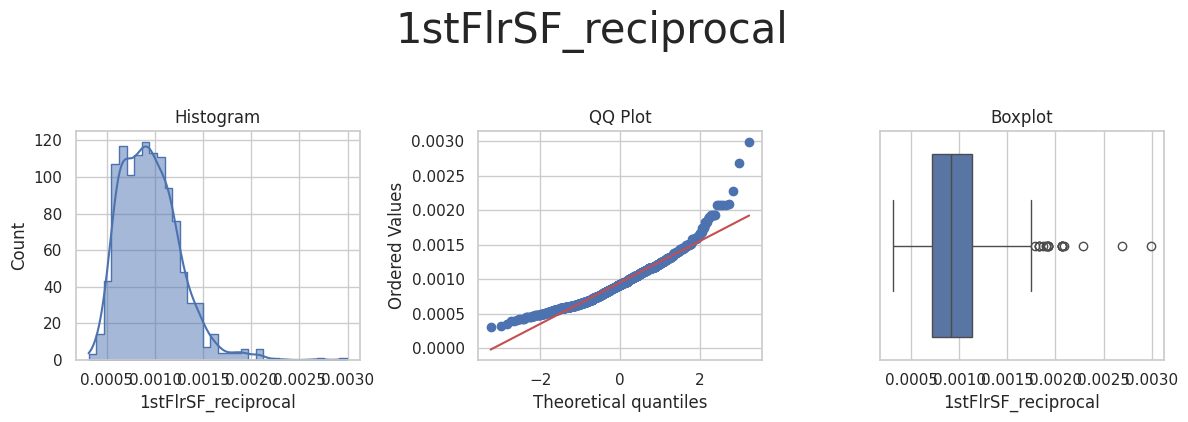

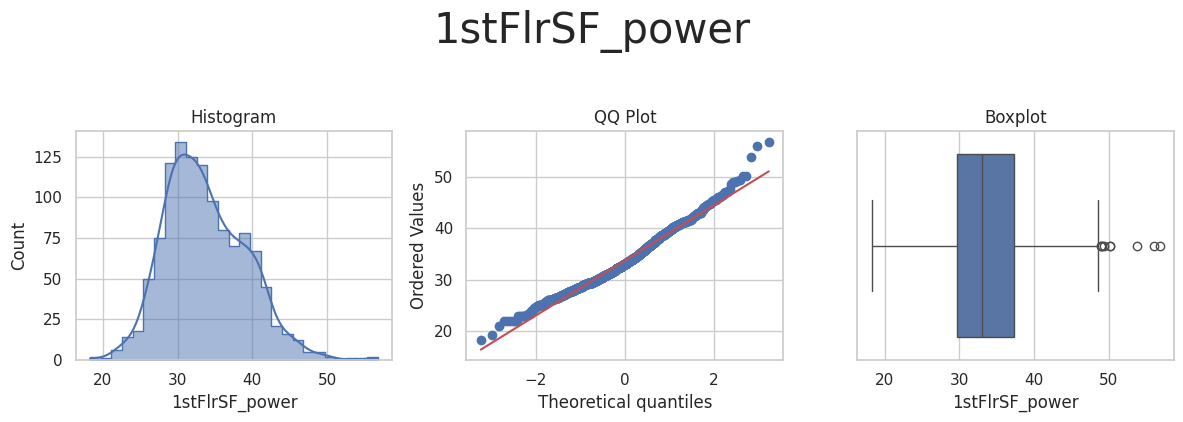

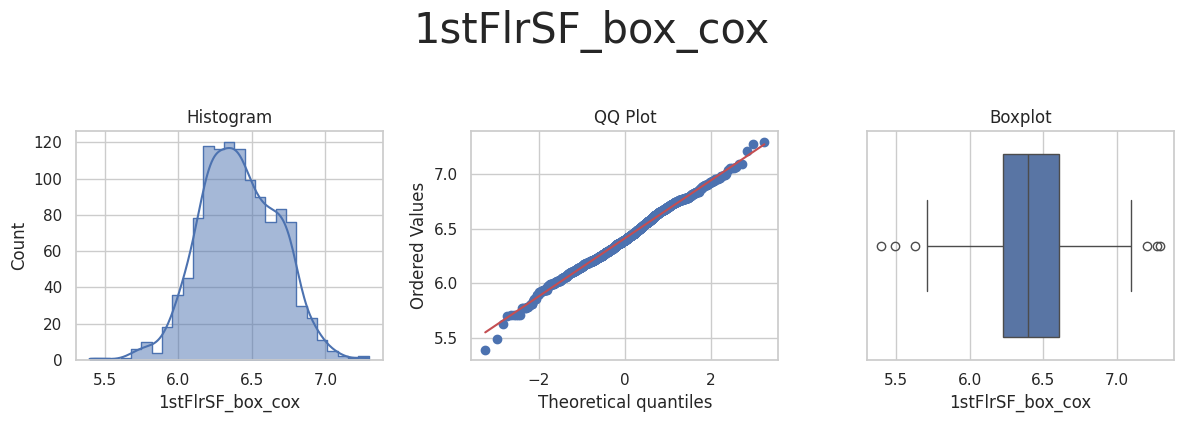

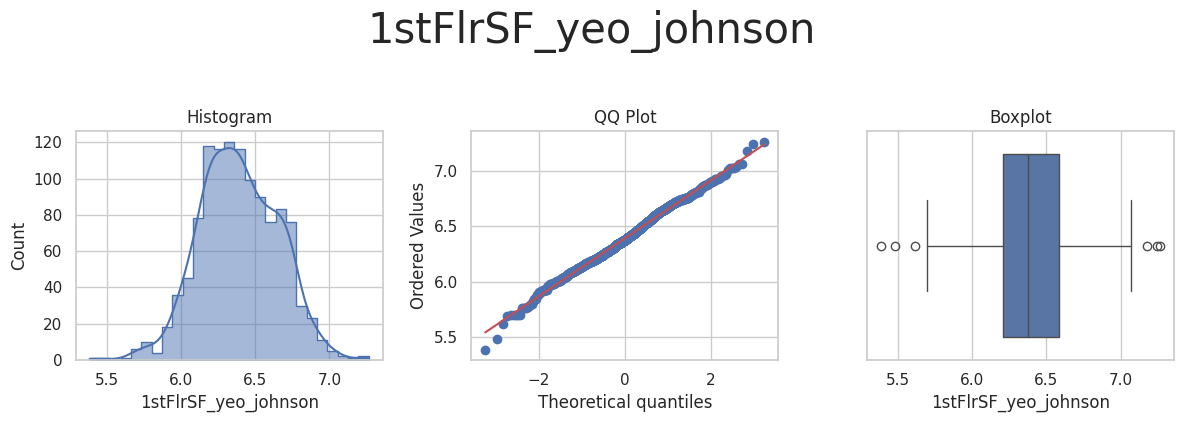



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



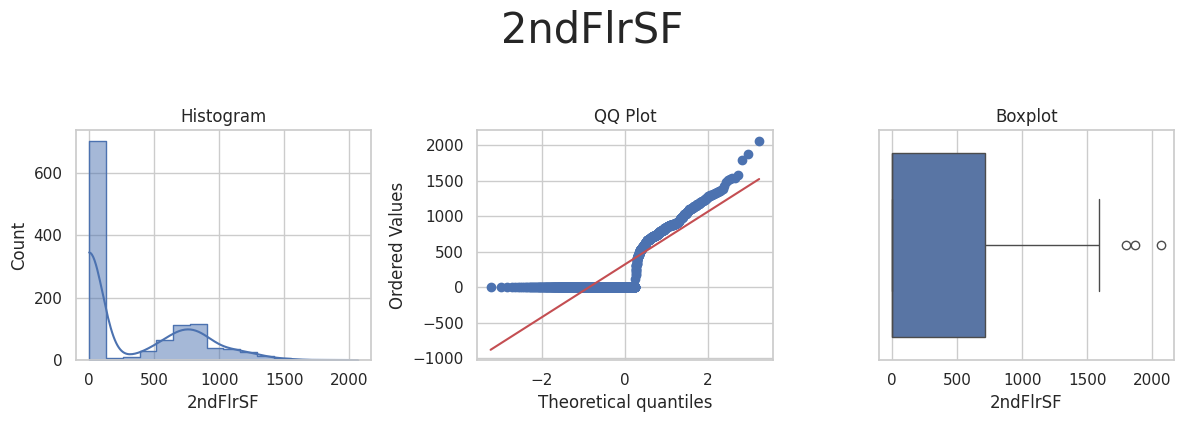

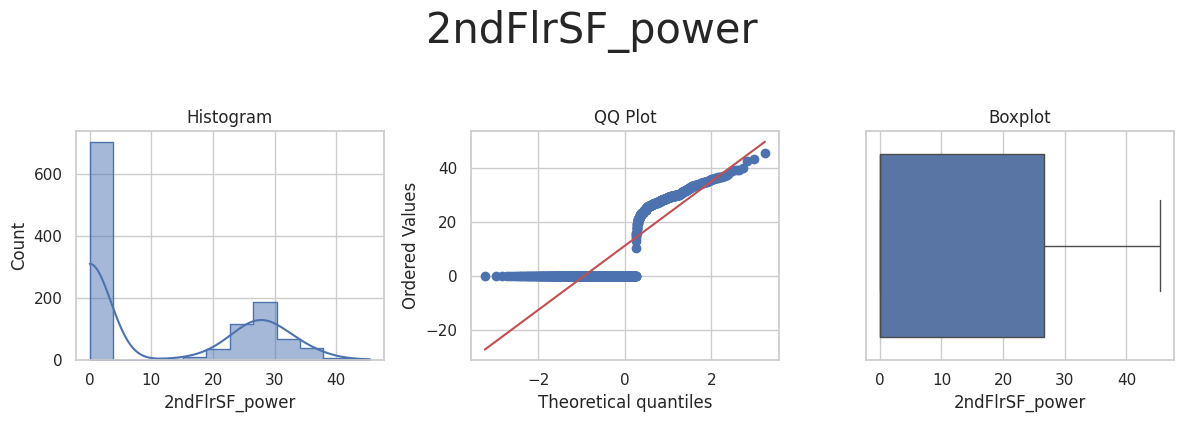

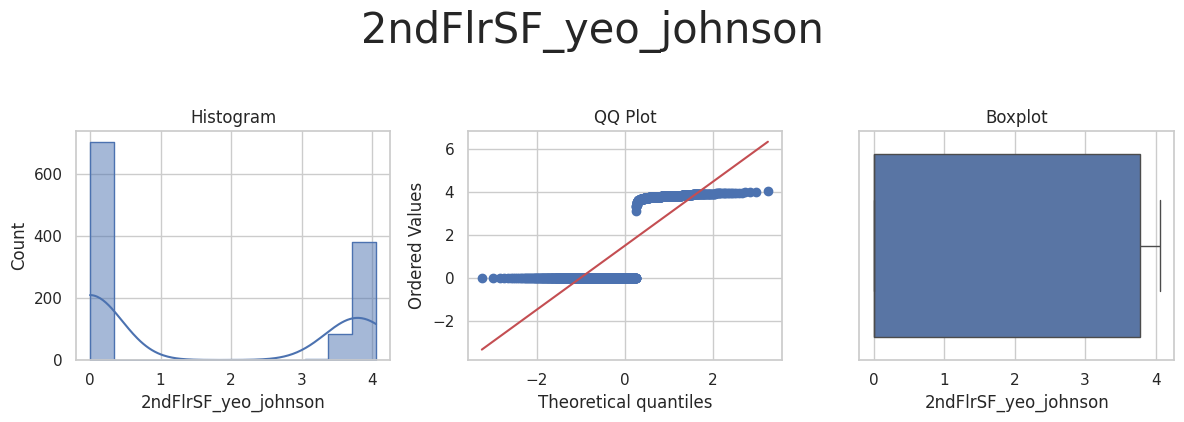



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



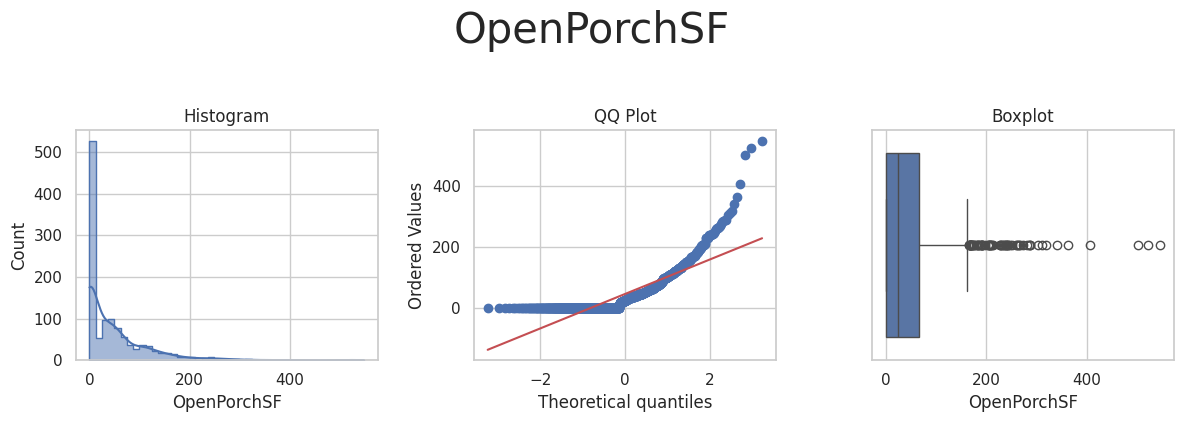

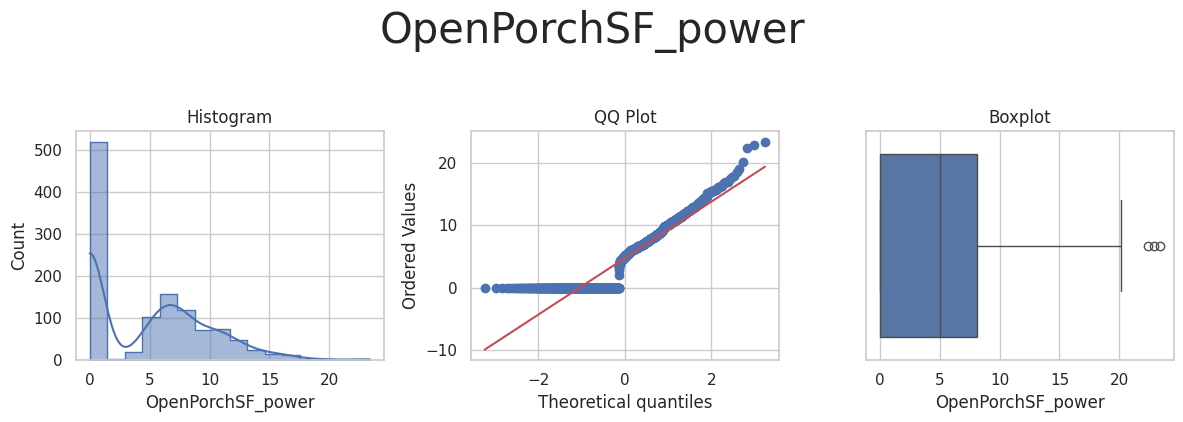

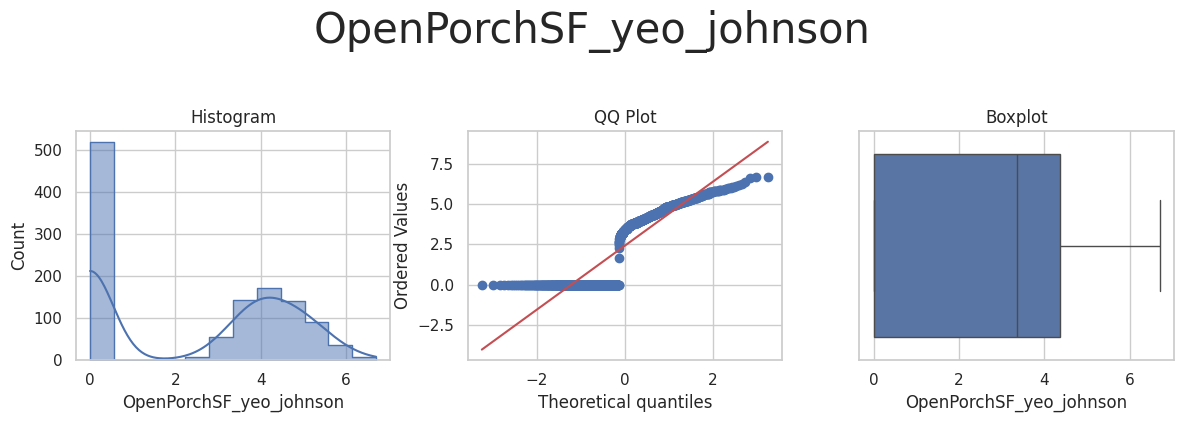

In [10]:
# Step 1: Select skewed numerical variables for transformation
# You can adjust this list based on skewness analysis or visual inspection

variables_engineering = [
    'LotArea', 'GrLivArea', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
    'OpenPorchSF'
]

# Step 2: Create a clean working copy of those variables
df_engineering = df_train[variables_engineering].copy()

# Step 3: Apply the transformation analysis
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

### Identify and Transform Skewed Numerical Variables

In [11]:
# Select best transformed versions again
selected_columns = [
    'LotArea_yeo_johnson',
    'GrLivArea_yeo_johnson',
    '1stFlrSF_log_e',
    'TotalBsmtSF_yeo_johnson'  # corrected spelling here!
]

df_transformed = df_engineering[selected_columns]

# Merge into the full feature set
X_train_updated = pd.concat([
    df_train.drop(columns=['LotArea', 'GrLivArea', '1stFlrSF', 'TotalBsmtSF']),
    df_transformed
], axis=1)


---

NOTE

* You may add as many sections as you want, as long as they support your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
